## Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# ! pip install aif360
# ! pip install cvxpy
# ! pip install BlackBoxAuditing

# import aif360
!pip uninstall numpy
!pip install numpy
! pip install ctgan
! pip install --upgrade category_encoders


# ! pip install table_evaluator
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime
import pprint
import json


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.25.2
  Using cached numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<

In [2]:
# Record the start time
start_time = time.time()

## Fairness metrics and functions


In [3]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    ,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

In [4]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    print('bias metrics:')
    print('equal opportunity for tpr: (close to 0)', op_diff)
    print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    print('avarage absolute odds difference: (close to 0)',od_diff)
    print('statistical parity difference: (close to 0) ',par_diff)
    print('disparate_impact: (close to 1) ',dis_impact)

#     # Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Bar colors
#     colors = ['blue', 'orange']

#     # Plot 1 - orig_data_one_priv and orig_data_one_non_priv
#     axs[0].bar(['priv', 'non_priv'], [tpr_0, tpr_1], color=colors)
#     axs[0].set_xlabel('Data Type')
#     axs[0].set_ylabel('Count')
#     axs[0].set_title('TPR(maximize)')

#     # Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
#     axs[1].bar(['priv', 'non_priv'], [fpr_0, fpr_1], color=colors)
#     axs[1].set_xlabel('Data Type')
#     axs[1].set_ylabel('Count')
#     axs[1].set_title('FPR(minimize)')

#     # Adjust spacing between subplots
#     plt.subplots_adjust(wspace=0.4)

#     # Show the plots
#     plt.show()

    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [5]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [6]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [7]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

## Datasets & Params¶


In [8]:
# choose dataset
#DATASET_NAME = 'ADULT_SEX'
#DATASET_NAME = 'ADULT_RACE'
#DATASET_NAME ='COMPAS_RACE_AM'
#DATASET_NAME = 'COMPAS_SEX'
#DATASET_NAME='CREDIT_SEX'
DATASET_NAME = 'BANK_AGE'



In [9]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!mkdir /root/.kaggle/
# Installing the Kaggle package
!pip install kaggle

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"guyrozenblatt","key":"e2ba3aff97edbcc7b8ab392e91dd8c65"}


# creating kaggle.json file with the personal API-Key details
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json


!mkdir ./datasets/compastwoyears/compas-scores-two-years_v1.csv


Saving bank.csv to bank.csv
User uploaded file "bank.csv" with length 918960 bytes
mv: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mkdir: cannot create directory ‘./datasets/compastwoyears/compas-scores-two-years_v1.csv’: No such file or directory


In [10]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = "black"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)

    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    orig_data['age'] = orig_data['age'].astype('int')
    orig_data['two_year_recid'] = orig_data['two_year_recid'].astype('int')
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    orig_data['age'] = orig_data['age'].astype('int')
    orig_data['two_year_recid'] = orig_data['two_year_recid'].astype('int')
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']

elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/content//bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

## Data_Visualization

In [11]:
# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]
# data = data[feature_columns]
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(orig_data, y_orig)
orig_data_encoded = encoder.transform(orig_data)

In [12]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)


In [13]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_dataset.groupby(orig_dataset[TARGET_COL] == 0)]

#Based on priv feature
orig_data_one_priv, orig_data_one_non_priv = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
orig_data_zero_priv, orig_data_zero_non_priv = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(orig_data_one_priv.shape,orig_data_one_non_priv.shape,orig_data_zero_priv.shape,orig_data_zero_non_priv.shape)

(527, 18) (4762, 18) (153, 18) (5720, 18)


In [14]:
maximum = max(orig_data_zero_priv.shape,orig_data_zero_non_priv.shape,orig_data_one_priv.shape,orig_data_one_non_priv.shape)
if maximum == orig_data_zero_priv.shape:
    print("orig_data_zero_priv is maximum")
if maximum == orig_data_zero_non_priv.shape:
    print("orig_data_zero_non_priv is maximum")
if maximum == orig_data_one_priv.shape:
    print("orig_data_one_priv is maximum")
if maximum == orig_data_one_non_priv.shape:
    print("orig_data_one_non_priv is maximum")

orig_data_zero_non_priv is maximum


In [15]:
maximum = maximum[0]
print(maximum)

5720


In [16]:
orig_data_zero_priv.shape[0]

153

In [17]:
orig_data_one_non_priv

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,age_cat,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5282,43,technician,divorced,unknown,no,4389,no,no,cellular,8,apr,618,1,-1,1,0,unknown,1
5283,45,admin.,divorced,secondary,no,0,no,no,cellular,29,oct,264,1,-1,1,0,unknown,1
5285,30,management,single,tertiary,no,398,no,no,cellular,27,oct,102,1,180,1,3,success,1
5287,48,entrepreneur,married,secondary,no,0,no,yes,cellular,28,jul,431,2,-1,1,0,unknown,1


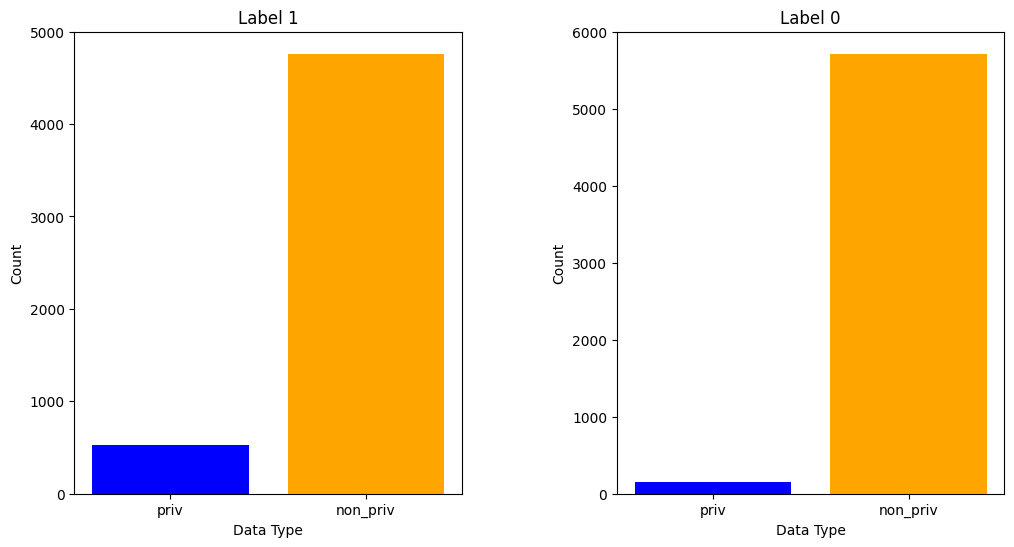

In [18]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [orig_data_one_priv.shape[0], orig_data_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [orig_data_zero_priv.shape[0], orig_data_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

In [19]:
orig_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,age_cat,previous,poutcome
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,1,0,unknown
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,1,0,unknown
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,1,0,unknown
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,1,0,unknown
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,1,0,unknown
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,1,0,unknown
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,1,0,unknown
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,1,5,failure


## Acc, fairness metrics and roc & auc for original dataset

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[972 203]
 [160 898]] 
accuracy:  0.8374384236453202 precision:  0.815622161671208 recall:  0.8487712665406427 fpr:  0.1727659574468085 tpr:  0.8487712665406427 fn+fp 363
performance for 0 sub-group:
conf matrix:
  [[956 186]
 [150 804]] 
accuracy:  0.8396946564885496 precision:  0.8121212121212121 recall:  0.8427672955974843 fpr:  0.1628721541155867 tpr:  0.8427672955974843 fn+fp 336
performance for 1 sub-group:
conf matrix:
  [[16 17]
 [10 94]] 
accuracy:  0.8029197080291971 precision:  0.8468468468468469 recall:  0.9038461538461539 fpr:  0.5151515151515151 tpr:  0.9038461538461539 fn+fp 27
bias metrics:
equal opportunity for tpr: (close to 0) 0.06107885824866954
equal opportunity for fpr: (close to 0) 0.35227936103592844
avarage absolute odds difference: (close to 0) 0.206679109642299
statistical parity difference: (close to 0)  0.7983651226158037
disparate_impact: (close to 1)  0.011303773429114029
p

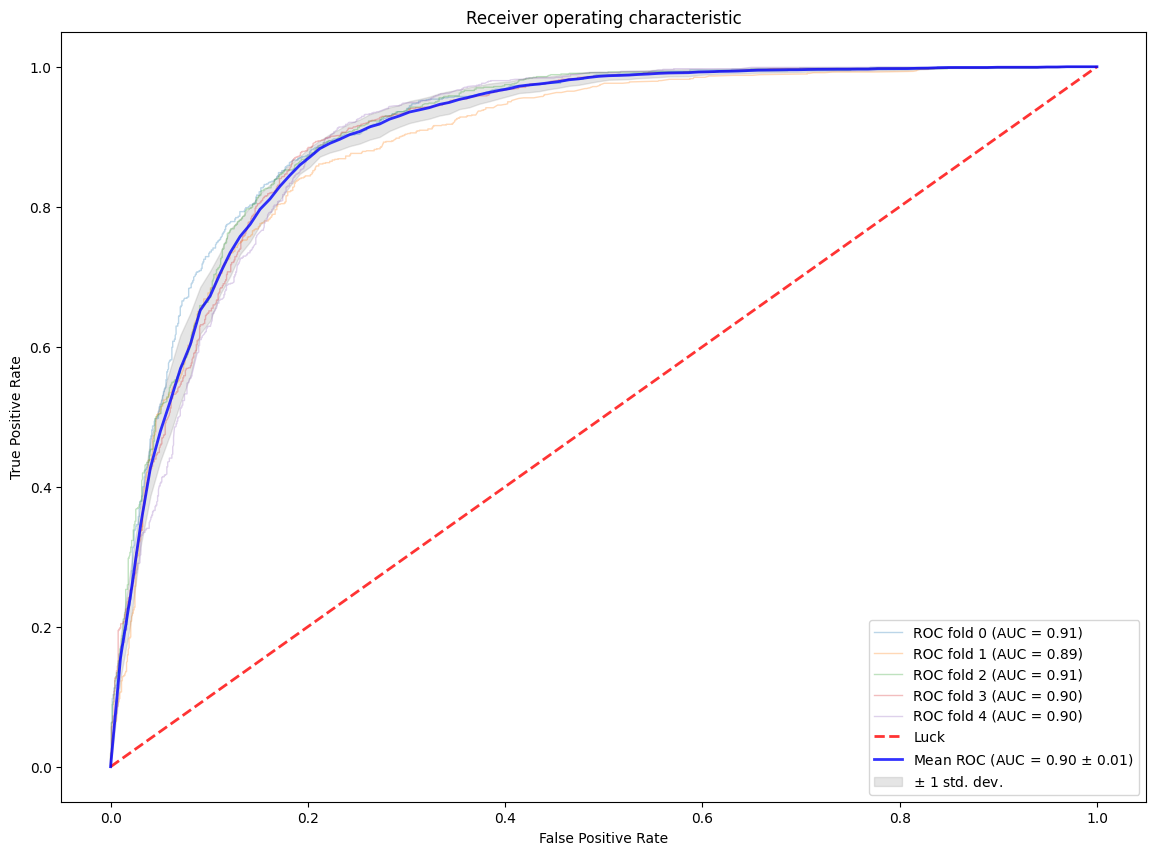

Accaracy list :  [0.8374384236453202, 0.8217644424540976, 0.8342293906810035, 0.8351254480286738, 0.8324372759856631]
equal opportunity for tpr :  [0.06107885824866954, 0.013556270096462986, 0.034226190476190466, 0.09238565488565487, 0.12679594801840344]
equal opportunity for fpr :  [0.35227936103592844, 0.21982780842398308, 0.3099705172875905, 0.47270007479431564, 0.5905238407699038]
odds difference list :  [0.206679109642299, 0.11669203926022303, 0.1720983538818905, 0.28254286483998525, 0.35865989439415363]
The mean accuracy is  0.832 ± 0.005
The mean equal opportunity for tpr: (close to 0) 0.066 ± 0.040
The mean equal opportunity for fpr: (close to 0) 0.389 ± 0.129
The mean odds difference: (close to 0) 0.227 ± 0.085
The mean parity difference: (close to 0) 0.798 ± 0.014
The mean disperate impact: (close to 1) 0.011 ± 0.002


In [20]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig)

  ## CTGANfor each group

In [21]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1


print(zero_priv_toincrease,zero_nonpriv_toincresed,one_priv_toincresed,one_nonpriv_toincresed)

5567 0 5193 958


In [22]:
orig_data_zero_priv

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,age_cat,previous,poutcome,deposit
5302,66,housemaid,married,secondary,no,1929,no,no,cellular,2,feb,169,1,-1,0,0,unknown,0
5312,67,unknown,married,tertiary,no,7687,no,no,telephone,30,oct,70,3,-1,0,0,unknown,0
5415,22,student,single,secondary,no,2162,no,no,telephone,2,feb,168,1,-1,0,0,unknown,0
5443,24,services,single,secondary,no,1299,yes,yes,cellular,18,may,113,2,-1,0,0,unknown,0
5446,74,retired,divorced,primary,no,166,no,no,cellular,13,aug,99,1,-1,0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10767,20,admin.,single,secondary,no,336,no,yes,cellular,5,jun,133,1,-1,0,0,unknown,0
10798,67,technician,married,secondary,no,0,no,no,cellular,13,aug,1152,2,188,0,1,success,0
10826,24,student,single,secondary,no,493,yes,no,cellular,13,may,85,4,358,0,1,other,0
10843,86,retired,divorced,unknown,no,157,no,no,telephone,7,sep,147,1,-1,0,0,unknown,0


# CTGAN On Priv Target Group

In [23]:
from ctgan import CTGAN

# Fit CTGAN for orig_data_zero_priv

ctgan_zero_priv = CTGAN(verbose=True)
ctgan_zero_priv.fit(orig_data_zero_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_zero_non_priv

ctgan_zero_nonpriv = CTGAN(verbose=True)
ctgan_zero_nonpriv.fit(orig_data_zero_non_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_priv

ctgan_one_priv = CTGAN(verbose=True)
ctgan_one_priv.fit(orig_data_one_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_non_priv

ctgan_one_nonpriv = CTGAN(verbose=True)
ctgan_one_nonpriv.fit(orig_data_one_non_priv , CATEGORICAL, epochs = 200)



/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c5fe5f62560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py

Epoch 1, Loss G:  1.2670,Loss D:  0.0039
Epoch 2, Loss G:  1.2617,Loss D: -0.0314
Epoch 3, Loss G:  1.2094,Loss D: -0.0409
Epoch 4, Loss G:  1.2361,Loss D: -0.0701
Epoch 5, Loss G:  1.1806,Loss D: -0.0909
Epoch 6, Loss G:  1.2328,Loss D: -0.1146
Epoch 7, Loss G:  1.1575,Loss D: -0.1530
Epoch 8, Loss G:  1.2182,Loss D: -0.1348
Epoch 9, Loss G:  1.1045,Loss D: -0.1900
Epoch 10, Loss G:  1.1529,Loss D: -0.2384
Epoch 11, Loss G:  1.1187,Loss D: -0.3141
Epoch 12, Loss G:  1.0418,Loss D: -0.3223
Epoch 13, Loss G:  0.9986,Loss D: -0.3170
Epoch 14, Loss G:  0.9930,Loss D: -0.3683
Epoch 15, Loss G:  0.9288,Loss D: -0.4757
Epoch 16, Loss G:  0.8188,Loss D: -0.4143
Epoch 17, Loss G:  0.7141,Loss D: -0.4422
Epoch 18, Loss G:  0.7522,Loss D: -0.3809
Epoch 19, Loss G:  0.6255,Loss D: -0.3678
Epoch 20, Loss G:  0.5043,Loss D: -0.3453
Epoch 21, Loss G:  0.3621,Loss D: -0.3206
Epoch 22, Loss G:  0.2647,Loss D: -0.2908
Epoch 23, Loss G:  0.4393,Loss D: -0.3596
Epoch 24, Loss G:  0.3071,Loss D: -0.2608
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.3508,Loss D: -0.3735
Epoch 2, Loss G:  0.4306,Loss D: -0.4009
Epoch 3, Loss G:  0.2741,Loss D: -0.0679
Epoch 4, Loss G:  0.0570,Loss D:  0.1640
Epoch 5, Loss G:  0.1915,Loss D:  0.1347
Epoch 6, Loss G:  0.0899,Loss D:  0.0941
Epoch 7, Loss G:  0.5344,Loss D: -0.0064
Epoch 8, Loss G:  0.5424,Loss D: -0.0095
Epoch 9, Loss G:  0.5199,Loss D:  0.0509
Epoch 10, Loss G:  0.5089,Loss D: -0.0783
Epoch 11, Loss G: -0.0876,Loss D:  0.2542
Epoch 12, Loss G: -0.1913,Loss D:  0.0929
Epoch 13, Loss G: -0.1300,Loss D: -0.0644
Epoch 14, Loss G: -0.3150,Loss D: -0.0759
Epoch 15, Loss G:  0.1659,Loss D: -0.1155
Epoch 16, Loss G: -0.4384,Loss D:  0.2956
Epoch 17, Loss G: -0.1853,Loss D: -0.1581
Epoch 18, Loss G: -0.3326,Loss D:  0.1517
Epoch 19, Loss G: -0.5035,Loss D:  0.0496
Epoch 20, Loss G:  0.0055,Loss D: -0.2165
Epoch 21, Loss G: -0.6792,Loss D:  0.2228
Epoch 22, Loss G: -0.6479,Loss D:  0.1708
Epoch 23, Loss G: -0.9051,Loss D: -0.0182
Epoch 24, Loss G: -0.7177,Loss D:  0.0730
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.3804,Loss D: -0.0033
Epoch 2, Loss G:  1.3718,Loss D: -0.0251
Epoch 3, Loss G:  1.4497,Loss D: -0.0223
Epoch 4, Loss G:  1.3956,Loss D: -0.0651
Epoch 5, Loss G:  1.4174,Loss D: -0.1010
Epoch 6, Loss G:  1.4086,Loss D: -0.1158
Epoch 7, Loss G:  1.4671,Loss D: -0.1347
Epoch 8, Loss G:  1.3755,Loss D: -0.1585
Epoch 9, Loss G:  1.3649,Loss D: -0.2272
Epoch 10, Loss G:  1.3797,Loss D: -0.2634
Epoch 11, Loss G:  1.2982,Loss D: -0.2677
Epoch 12, Loss G:  1.2812,Loss D: -0.3622
Epoch 13, Loss G:  1.2651,Loss D: -0.4021
Epoch 14, Loss G:  1.2274,Loss D: -0.4208
Epoch 15, Loss G:  1.1066,Loss D: -0.4170
Epoch 16, Loss G:  1.0932,Loss D: -0.4768
Epoch 17, Loss G:  1.0603,Loss D: -0.4498
Epoch 18, Loss G:  0.9593,Loss D: -0.4373
Epoch 19, Loss G:  0.8990,Loss D: -0.4499
Epoch 20, Loss G:  0.8383,Loss D: -0.5352
Epoch 21, Loss G:  0.6548,Loss D: -0.5194
Epoch 22, Loss G:  0.6337,Loss D: -0.5105
Epoch 23, Loss G:  0.5738,Loss D: -0.4722
Epoch 24, Loss G:  0.4994,Loss D: -0.3259
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.3812,Loss D: -0.2018
Epoch 2, Loss G:  1.2259,Loss D: -0.4839
Epoch 3, Loss G:  0.7511,Loss D: -0.1358
Epoch 4, Loss G:  0.4942,Loss D:  0.1196
Epoch 5, Loss G:  0.5290,Loss D:  0.1697
Epoch 6, Loss G:  0.4229,Loss D:  0.0869
Epoch 7, Loss G:  0.6899,Loss D: -0.0796
Epoch 8, Loss G:  0.7120,Loss D: -0.0264
Epoch 9, Loss G:  0.3330,Loss D:  0.1805
Epoch 10, Loss G:  0.3670,Loss D: -0.0820
Epoch 11, Loss G:  0.1979,Loss D: -0.0293
Epoch 12, Loss G: -0.2232,Loss D:  0.3304
Epoch 13, Loss G:  0.0534,Loss D: -0.1224
Epoch 14, Loss G:  0.1759,Loss D:  0.0281
Epoch 15, Loss G: -0.1916,Loss D:  0.2109
Epoch 16, Loss G:  0.1081,Loss D: -0.1245
Epoch 17, Loss G: -0.0514,Loss D:  0.1475
Epoch 18, Loss G: -0.2844,Loss D:  0.2341
Epoch 19, Loss G:  0.0180,Loss D: -0.1687
Epoch 20, Loss G: -0.2991,Loss D:  0.2535
Epoch 21, Loss G: -0.4371,Loss D:  0.1569
Epoch 22, Loss G: -0.2189,Loss D: -0.0375
Epoch 23, Loss G: -0.5380,Loss D:  0.0914
Epoch 24, Loss G: -0.1279,Loss D: -0.1982
E

In [24]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1

#create samples using ctgan with zero_priv
zero_priv_samples = ctgan_zero_priv.sample(zero_priv_toincrease)


#create samples using ctgan with zero_nonpriv
zero_nonpriv_samples = ctgan_zero_nonpriv.sample(zero_nonpriv_toincresed)


#create samples using ctgan with one_priv
one_priv_samples = ctgan_one_priv.sample(one_priv_toincresed)


#create samples using ctgan with zero_priv
one_nonpriv_samples = ctgan_one_nonpriv.sample(one_nonpriv_toincresed)



In [25]:
Upsampled_Dataset = pd.concat([orig_dataset, zero_priv_samples, zero_nonpriv_samples, one_priv_samples, one_nonpriv_samples], ignore_index=True)

Upsampled_Dataset = Upsampled_Dataset.reset_index()


In [26]:
Upsampled_Dataset

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,age_cat,previous,poutcome,deposit
0,0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,1,0,unknown,1
1,1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,1,0,unknown,1
2,2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,1,0,unknown,1
3,3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,1,0,unknown,1
4,4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22875,22875,55,management,married,secondary,no,3320,no,no,telephone,17,apr,622,1,0,1,1,unknown,1
22876,22876,24,services,single,secondary,no,819,no,no,cellular,8,jul,219,1,6,1,0,other,1
22877,22877,46,self-employed,married,secondary,no,37,no,no,unknown,15,jun,557,2,-3,1,0,unknown,1
22878,22878,45,admin.,married,secondary,no,157,no,yes,cellular,18,jun,540,1,2,1,0,unknown,1


In [27]:
Upsampled_df_features = Upsampled_Dataset.loc[:, feature_columns]
Upsampled_df_features
Upsampled_df_features = encoder.transform(Upsampled_df_features)
Upsampled_df_features

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,age_cat,previous,poutcome
0,59,0.473013,0.433790,0.447407,0.476351,2343,0.366408,0.495259,0.225916,5,0.327550,1042,1,-1,1,0,0.406678
1,56,0.473013,0.433790,0.447407,0.476351,45,0.570311,0.495259,0.225916,5,0.327550,1467,1,-1,1,0,0.406678
2,41,0.460779,0.433790,0.447407,0.476351,1270,0.366408,0.495259,0.225916,5,0.327550,1389,1,-1,1,0,0.406678
3,55,0.399783,0.433790,0.447407,0.476351,2476,0.366408,0.495259,0.225916,5,0.327550,579,1,-1,1,0,0.406678
4,54,0.473013,0.433790,0.541068,0.476351,184,0.570311,0.495259,0.225916,5,0.327550,673,2,-1,1,0,0.406678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22875,55,0.507015,0.433790,0.447407,0.476351,3320,0.570311,0.495259,0.503876,17,0.625135,622,1,0,1,1,0.406678
22876,24,0.399783,0.543491,0.447407,0.476351,819,0.570311,0.495259,0.543273,8,0.414135,219,1,6,1,0,0.571695
22877,46,0.461728,0.433790,0.447407,0.476351,37,0.570311,0.495259,0.225916,15,0.446809,557,2,-3,1,0,0.406678
22878,45,0.473013,0.433790,0.447407,0.476351,157,0.570311,0.331507,0.543273,18,0.446809,540,1,2,1,0,0.406678


In [28]:
y_upsampled = Upsampled_Dataset[TARGET_COL]
y_upsampled

0        1
1        1
2        1
3        1
4        1
        ..
22875    1
22876    1
22877    1
22878    1
22879    1
Name: deposit, Length: 22880, dtype: int64

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[1838  450]
 [ 295 1993]] 
accuracy:  0.8371940559440559 precision:  0.8158002455996726 recall:  0.8710664335664335 fpr:  0.19667832167832167 tpr:  0.8710664335664335 fn+fp 745
performance for 0 sub-group:
conf matrix:
  [[ 805  319]
 [  89 1078]] 
accuracy:  0.8219118288956787 precision:  0.7716535433070866 recall:  0.9237360754070265 fpr:  0.28380782918149466 tpr:  0.9237360754070265 fn+fp 408
performance for 1 sub-group:
conf matrix:
  [[1033  131]
 [ 206  915]] 
accuracy:  0.8525164113785558 precision:  0.8747609942638623 recall:  0.8162355040142729 fpr:  0.11254295532646048 tpr:  0.8162355040142729 fn+fp 337
bias metrics:
equal opportunity for tpr: (close to 0) 0.1075005713927536
equal opportunity for fpr: (close to 0) 0.1712648738550342
avarage absolute odds difference: (close to 0) 0.1393827226238939
statistical parity difference: (close to 0)  0.14367580843225541
disparate_impact: (close to 1)  0

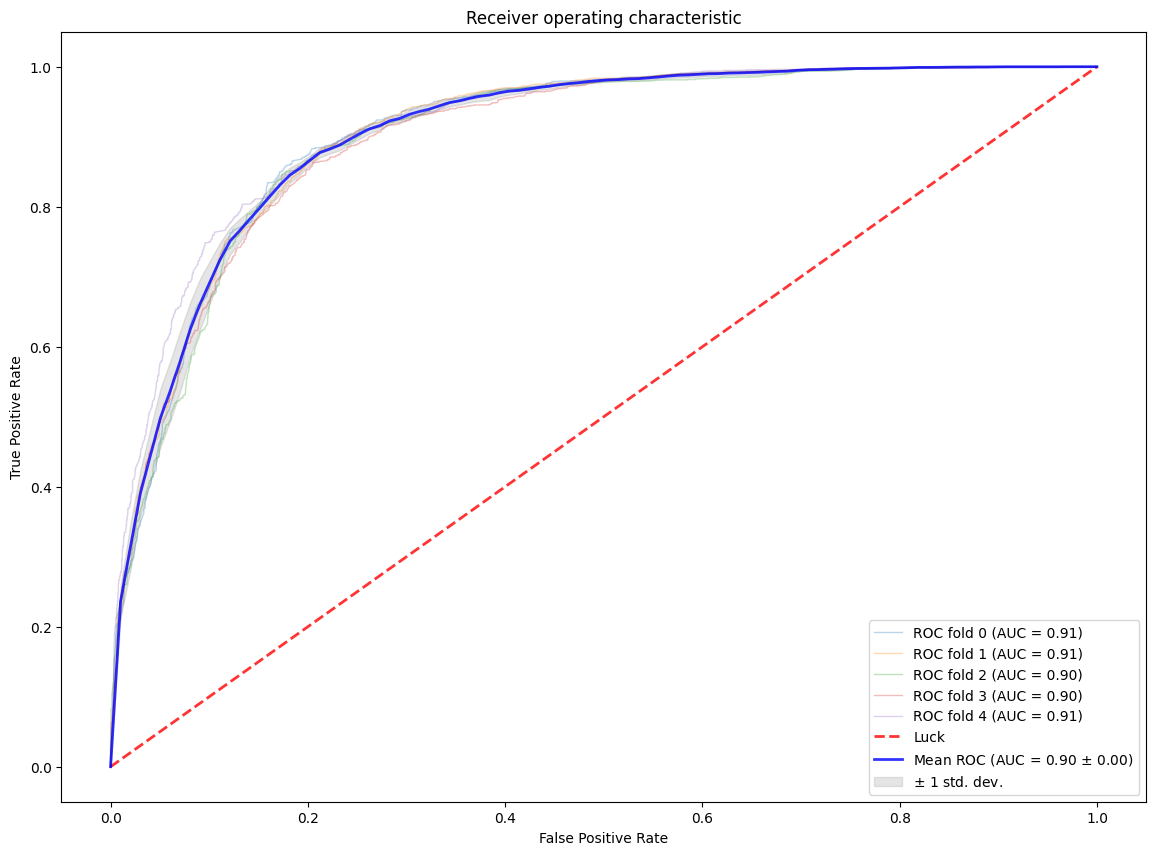

Accaracy list :  [0.8371940559440559, 0.8282342657342657, 0.8334790209790209, 0.8214597902097902, 0.8332604895104895]
equal opportunity for tpr :  [0.1075005713927536, 0.07755586528005398, 0.08744588744588744, 0.05311312068524188, 0.0739237592844676]
equal opportunity for fpr :  [0.1712648738550342, 0.16918059705942384, 0.19108365949119374, 0.17041227692147817, 0.16447590184171004]
odds difference list :  [0.1393827226238939, 0.12336823116973891, 0.1392647734685406, 0.11176269880336002, 0.11919983056308882]
The mean accuracy is  0.831 ± 0.005
The mean equal opportunity for tpr: (close to 0) 0.080 ± 0.018
The mean equal opportunity for fpr: (close to 0) 0.173 ± 0.009
The mean odds difference: (close to 0) 0.127 ± 0.011
The mean parity difference: (close to 0) 0.118 ± 0.024
The mean disperate impact: (close to 1) 0.349 ± 0.026


In [29]:
y_upsampled = Upsampled_Dataset[TARGET_COL]

# Check fairness metrics again
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Store metrics values
# op_diff_values.append(mean(debias_op_diff))
# dis_impact_values.append(mean(debias_dis_impact))
# debias_acc_values.append(mean(debias_acc))
# debias_odds_diff_values.append(mean(debias_od_diff))
# alfa_counter += 1
# print('alfa counter is :',alfa_counter)
# print ('debias_op_diff is {} , orig_op_diff is {}'.format(mean(debias_op_diff), mean(orig_op_diff)))
# print ('debias_dis_impact is {} , orig_dis_impact is {}'.format(mean(debias_dis_impact), mean(orig_dis_impact)) )

In [30]:
#Based on class
Upsampled_Dataset_one , Upsampled_Dataset_zero = [x for _, x in Upsampled_Dataset.groupby(Upsampled_Dataset[TARGET_COL] == 0)]

#Based on priv feature
Upsampled_df_one_priv, Upsampled_df_one_non_priv = [x for _, x in Upsampled_Dataset_one.groupby(Upsampled_Dataset_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
Upsampled_df_zero_priv, Upsampled_df_zero_non_priv = [x for _, x in Upsampled_Dataset_zero.groupby(Upsampled_Dataset_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(Upsampled_df_one_priv.shape,Upsampled_df_one_non_priv.shape,Upsampled_df_zero_priv.shape,Upsampled_df_zero_non_priv.shape)

(5720, 19) (5720, 19) (5720, 19) (5720, 19)


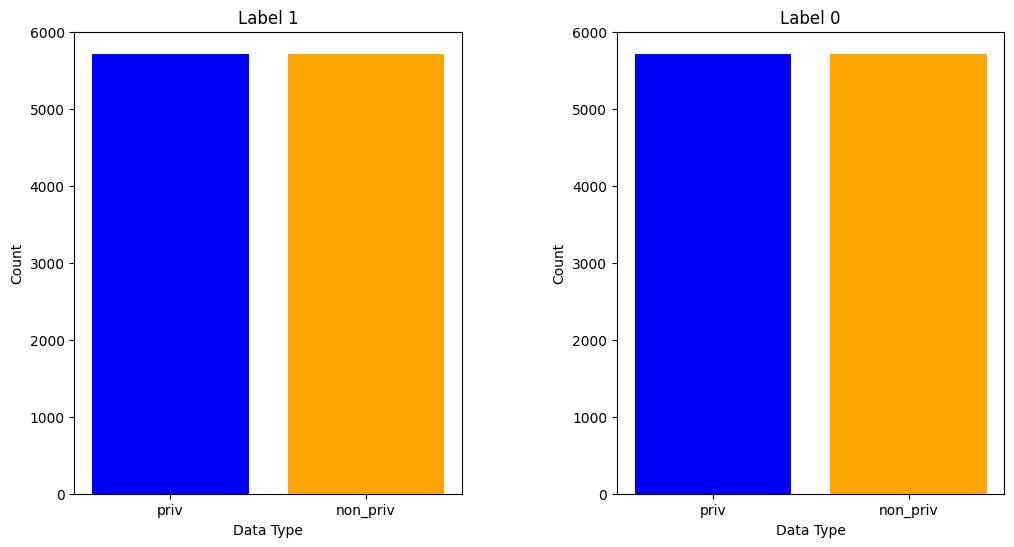

In [31]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [Upsampled_df_one_priv.shape[0], Upsampled_df_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [Upsampled_df_zero_priv.shape[0], Upsampled_df_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[1860  428]
 [ 305 1983]] 
accuracy:  0.8398164335664335 precision:  0.8224802986312734 recall:  0.8666958041958042 fpr:  0.18706293706293706 tpr:  0.8666958041958042 fn+fp 733
performance for 0 sub-group:
conf matrix:
  [[ 813  311]
 [ 112 1055]] 
accuracy:  0.8153644696639022 precision:  0.7723279648609077 recall:  0.9040274207369323 fpr:  0.27669039145907476 tpr:  0.9040274207369323 fn+fp 423
performance for 1 sub-group:
conf matrix:
  [[1047  117]
 [ 193  928]] 
accuracy:  0.8643326039387309 precision:  0.8880382775119617 recall:  0.8278322925958965 fpr:  0.10051546391752578 tpr:  0.8278322925958965 fn+fp 310
bias metrics:
equal opportunity for tpr: (close to 0) 0.0761951281410358
equal opportunity for fpr: (close to 0) 0.17617492754154898
avarage absolute odds difference: (close to 0) 0.12618502784129237
statistical parity difference: (close to 0)  0.13313977602654498
disparate_impact: (close to 1) 

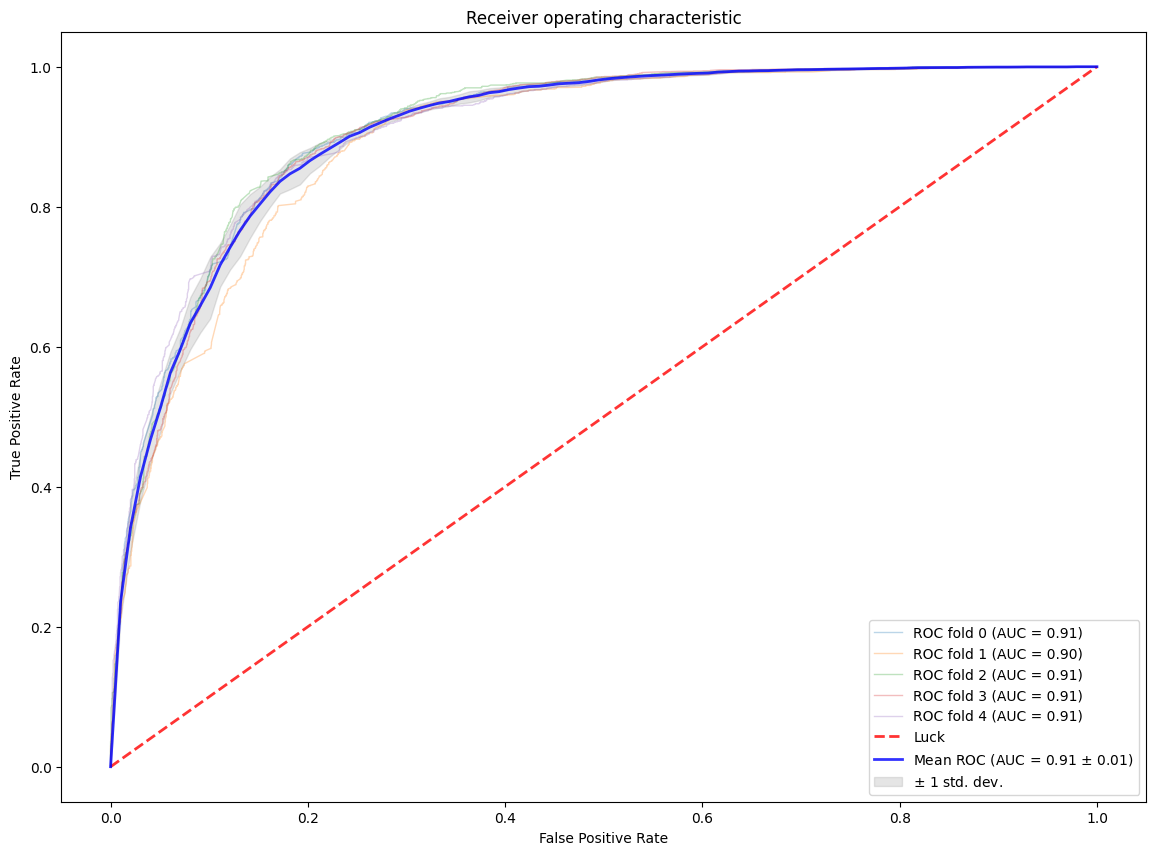

Accaracy list :  [0.8398164335664335, 0.8229895104895105, 0.8380681818181818, 0.8378496503496503, 0.8299825174825175]
equal opportunity for tpr :  [0.0761951281410358, 0.08228546047694174, 0.07379481360063878, 0.019865748222520185, 0.07522685587965905]
equal opportunity for fpr :  [0.17617492754154898, 0.25305115544475965, 0.18006360078277886, 0.12215946427534435, 0.19067641472297914]
odds difference list :  [0.12618502784129237, 0.1676683079608507, 0.1269292071917088, 0.07101260624893227, 0.1329516353013191]
The mean accuracy is  0.834 ± 0.006
The mean equal opportunity for tpr: (close to 0) 0.065 ± 0.023
The mean equal opportunity for fpr: (close to 0) 0.184 ± 0.042
The mean odds difference: (close to 0) 0.125 ± 0.031
The mean parity difference: (close to 0) 0.116 ± 0.030
The mean disperate impact: (close to 1) 0.352 ± 0.034


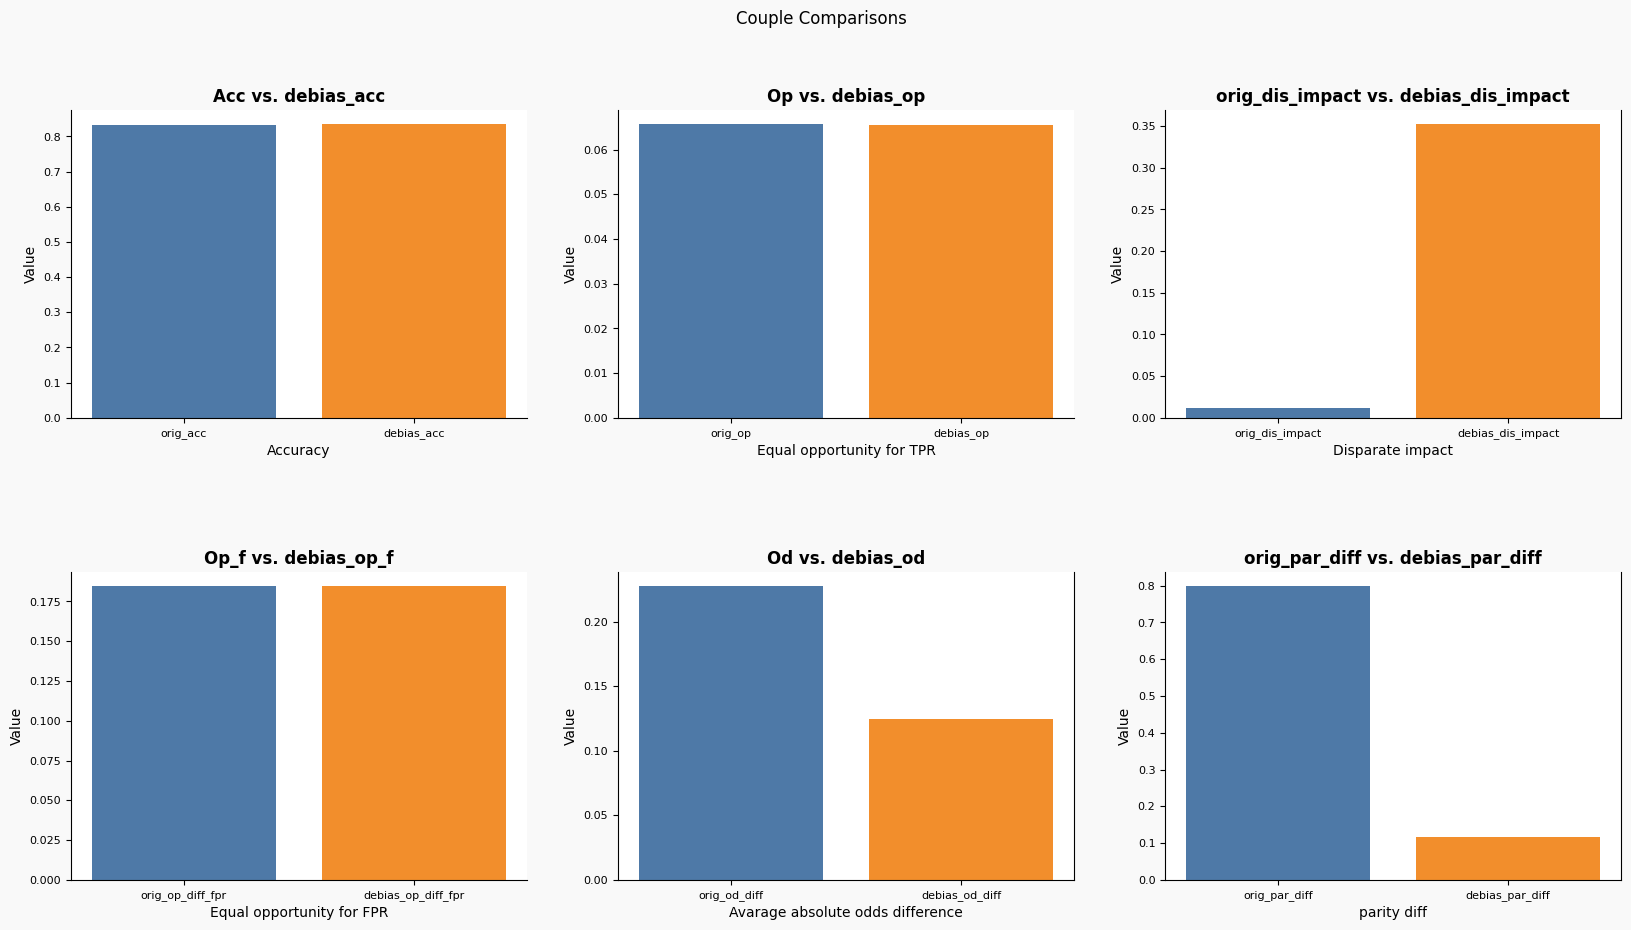

In [32]:
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Initialize wandb
# wandb.init(project="couple-comparisons")

# Create a bar plot for each couple comparison
fig, ax = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Couple Comparisons')

# Set background color
fig.patch.set_facecolor('#f9f9f9')

# Acc vs. Pois_acc plot
ax[0, 0].bar(['orig_acc', 'debias_acc'], [mean(orig_acc), mean(upsampled_acc)], color=['#4e79a7', '#f28e2c'])
ax[0, 0].set_title('Acc vs. debias_acc', fontsize=12, fontweight='bold')
ax[0, 0].set_xlabel('Accuracy', fontsize=10)
ax[0, 0].set_ylabel('Value', fontsize=10)
ax[0, 0].tick_params(axis='both', which='major', labelsize=8)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

# Op vs. Pois_op plot
ax[0, 1].bar(['orig_op','debias_op'], [mean(orig_op_diff), mean(upsampled_op_diff)], color=['#4e79a7', '#f28e2c'])
ax[0, 1].set_title('Op vs. debias_op', fontsize=12, fontweight='bold')
ax[0, 1].set_xlabel('Equal opportunity for TPR', fontsize=10)
ax[0, 1].set_ylabel('Value', fontsize=10)
ax[0, 1].tick_params(axis='both', which='major', labelsize=8)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# Op_f vs. Pois_op_f plotdebias
ax[1, 0].bar(['orig_op_diff_fpr', 'debias_op_diff_fpr'], [mean(upsampled_op_diff_fpr), mean(upsampled_op_diff_fpr)], color=['#4e79a7', '#f28e2c'])
ax[1, 0].set_title('Op_f vs. debias_op_f', fontsize=12, fontweight='bold')
ax[1, 0].set_xlabel('Equal opportunity for FPR', fontsize=10)
ax[1, 0].set_ylabel('Value', fontsize=10)
ax[1, 0].tick_params(axis='both', which='major', labelsize=8)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

# Od vs. Pois_od plot
ax[1, 1].bar(['orig_od_diff', 'debias_od_diff'], [mean(orig_od_diff), mean(upsampled_od_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 1].set_title('Od vs. debias_od', fontsize=12, fontweight='bold')
ax[1, 1].set_xlabel('Avarage absolute odds difference', fontsize=10)
ax[1, 1].set_ylabel('Value', fontsize=10)
ax[1, 1].tick_params(axis='both', which='major', labelsize=8)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines

# Od vs. Pois_od plot
ax[1, 2].bar(['orig_par_diff', 'debias_par_diff'], [mean(orig_par_diff), mean(upsampled_par_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 2].set_title('orig_par_diff vs. debias_par_diff', fontsize=12, fontweight='bold')
ax[1, 2].set_xlabel('parity diff', fontsize=10)
ax[1, 2].set_ylabel('Value', fontsize=10)
ax[1, 2].tick_params(axis='both', which='major', labelsize=8)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].spines

# Od vs. Pois_od plot
ax[0, 2].bar(['orig_dis_impact', 'debias_dis_impact'], [mean(orig_dis_impact), mean(upsampled_dis_impact)], color=['#4e79a7', '#f28e2c'])
ax[0, 2].set_title('orig_dis_impact vs. debias_dis_impact', fontsize=12, fontweight='bold')
ax[0, 2].set_xlabel('Disparate impact', fontsize=10)
ax[0, 2].set_ylabel('Value', fontsize=10)
ax[0, 2].tick_params(axis='both', which='major', labelsize=8)
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].spines



In [33]:
# Record the end time
end_time = time.time()

In [34]:
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.4f} minutes")

Elapsed time: 4.4243 minutes
